In [779]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [780]:
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', delimiter=",")[::-1]
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)
df

,Price
Datetime,
2024-11-21 23:00:00,107.46
2024-11-21 22:00:00,122.90
2024-11-21 21:00:00,123.05
2024-11-21 20:00:00,131.33
2024-11-21 19:00:00,154.05
...,...
2018-10-01 04:00:00,47.59
2018-10-01 03:00:00,47.38
2018-10-01 02:00:00,51.41


In [781]:
mix_df = pd.read_csv('../../data/hourly_market_mix_cleaned.csv', delimiter=",")[::-1]
mix_df.set_index("Timestamp", inplace=True)
mix_df.index = pd.to_datetime(mix_df.index)
mix_df.rename_axis("Datetime", inplace=True) 
mix_df = mix_df.loc[:, mix_df.max() >= 0.01]

In [782]:
merged_df = df.merge(mix_df, how='inner', left_index=True, right_index=True)
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,,
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.000000,0.049146,0.000022,0.0,0.047519,0.107476
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.000000,0.046156,0.000599,0.0,0.040935,0.102369
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.000000,0.046154,0.001140,0.0,0.035149,0.097447
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.000000,0.046835,0.002805,0.0,0.030024,0.096333
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.000000,0.044794,0.014459,0.0,0.027928,0.097331
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,0.092527,0.148990,0.019701,0.282126,0.146368,0.138012,0.040888,0.003391,0.0,0.045451,0.082545
2018-10-01 03:00:00,47.38,0.093932,0.146157,0.020071,0.286085,0.153114,0.140053,0.041441,0.003452,0.0,0.039751,0.075943
2018-10-01 02:00:00,51.41,0.094656,0.139489,0.020001,0.286402,0.161350,0.142441,0.041791,0.003471,0.0,0.038929,0.071471


In [783]:
TEST_SIZE = 0.18

SPLIT_DATE_EVAL = merged_df.index[int(TEST_SIZE * len(merged_df))]


train = merged_df.loc[merged_df.index < SPLIT_DATE_EVAL]
initial_test = merged_df.loc[merged_df.index >= SPLIT_DATE_EVAL]


test_eval_split = int(len(initial_test) / 2)

SPLIT_DATE_TEST = merged_df.index[int(TEST_SIZE * len(merged_df)) - test_eval_split - 1]

test = initial_test.iloc[:test_eval_split]
eval = initial_test.iloc[test_eval_split:]

eval

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore
Datetime,,,,,,,,,,,,
2024-04-12 17:00:00,57.37,0.084674,0.017899,0.044440,0.077898,0.132564,0.0,0.036925,0.007586,0.277852,0.066440,0.253722
2024-04-12 16:00:00,0.22,0.071990,0.014774,0.039949,0.054478,0.106525,0.0,0.030741,0.000887,0.365533,0.072082,0.243041
2024-04-12 15:00:00,0.18,0.064289,0.014542,0.035330,0.048058,0.094356,0.0,0.027463,0.000512,0.418821,0.069718,0.226909
2024-04-12 14:00:00,0.01,0.059697,0.017247,0.033430,0.046278,0.088183,0.0,0.025579,0.000441,0.449089,0.069300,0.210756
2024-04-12 13:00:00,-0.07,0.059205,0.017442,0.031908,0.050033,0.087802,0.0,0.025841,0.000090,0.454611,0.072151,0.200917
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25 13:00:00,76.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-25 12:00:00,76.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-25 11:00:00,89.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


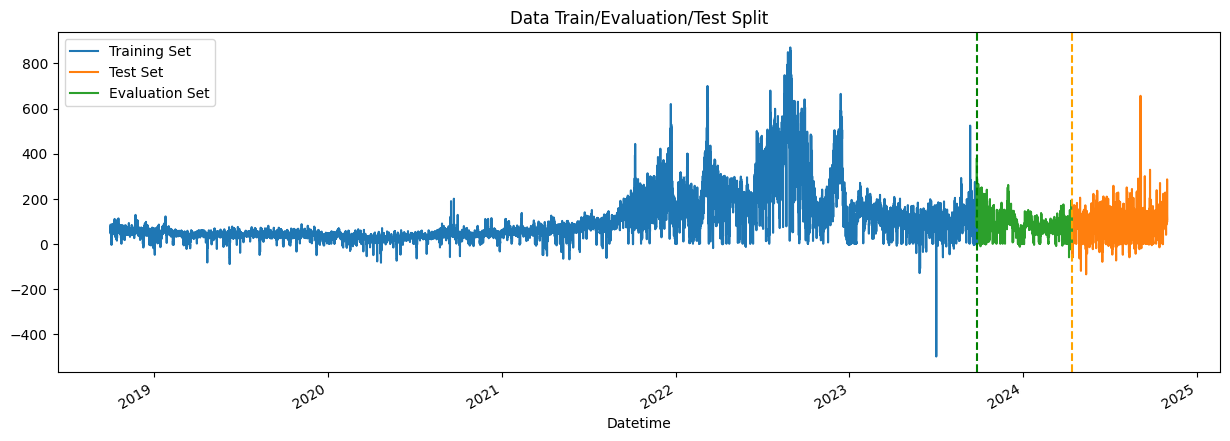

In [784]:
fig, ax = plt.subplots(figsize=(15, 5))
train["Price"].plot(ax=ax, label='Training Set', title='Data Train/Evaluation/Test Split')
test["Price"].plot(ax=ax, label='Test Set')
eval["Price"].plot(ax=ax, label='Evaluation Set')
ax.axvline(SPLIT_DATE_EVAL, color='green', ls='--')
ax.axvline(SPLIT_DATE_TEST, color='orange', ls='--')
ax.legend(['Training Set', 'Test Set', 'Evaluation Set'])
plt.show()

In [785]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-11-21 23:00:00,107.46,23,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 22:00:00,122.90,22,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 21:00:00,123.05,21,3,326,47,117.803333,NaN,NaN,NaN,NaN,NaN
2024-11-21 20:00:00,131.33,20,3,326,47,125.760000,NaN,NaN,NaN,NaN,NaN
2024-11-21 19:00:00,154.05,19,3,326,47,136.143333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,4,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.385298
2018-10-01 03:00:00,47.38,3,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.385655
2018-10-01 02:00:00,51.41,2,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.393095


In [786]:
train = create_features(train)
test = create_features(test)
eval = create_features(eval)

FEATURES = [
    "hour",
    "dayofyear",
    "dayofweek",
    "ma_3_hours",
    "ma_6_hours",
    "ma_1_days",
    "ma_3_days",
    "ma_7_days",
    "Biomass",
    "Hard Coal",
    "Hydro",
    "Lignite",
    "Natural Gas",
    "Nuclear",
    "Other",
    "Pumped storage generation",
    "Solar",
    "Wind offshore",
    "Wind onshore",
]
TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

best_params = {
    "base_score": np.float64(0.3888133835396405),
    "colsample_bytree": np.float64(0.6349243426308729),
    "early_stopping_rounds": np.int64(4),
    "gamma": np.float64(0.2753854688925828),
    "learning_rate": np.float64(0.05),
    "max_depth": np.int64(50),
    "min_child_weight": np.int64(7),
    "n_estimators": np.int64(200),
    "subsample": np.float64(0.5719023844219375),
}

reg = xgb.XGBRegressor(
    base_score=best_params["base_score"],
    colsample_bytree=best_params["colsample_bytree"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    gamma=best_params["gamma"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    objective="reg:squarederror",
    reg_lambda=0.8
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=25)

[0]	validation_0-rmse:136.40772	validation_1-rmse:80.41850
[25]	validation_0-rmse:40.21483	validation_1-rmse:25.42076
[50]	validation_0-rmse:13.78360	validation_1-rmse:12.43239
[75]	validation_0-rmse:6.70738	validation_1-rmse:10.37097
[100]	validation_0-rmse:4.51801	validation_1-rmse:10.12681
[110]	validation_0-rmse:4.06546	validation_1-rmse:10.07422


XGBRegressor(base_score=np.float64(0.3888133835396405), booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6349243426308729), device=None,
             early_stopping_rounds=np.int64(4), enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.2753854688925828), grow_policy=None,
             importance_ty..., interaction_constraints=None,
             learning_rate=np.float64(0.05), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=np.int64(50), max_leaves=None,
             min_child_weight=np.int64(7), missing=nan,
             monotone_constraints=None, multi_strategy=None,
             n_estimators=np.int64(200), n_jobs=None, num_parallel_tree=None,
             random_state=None, ...)

In [787]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

with open(f"./pickle/benchmark_emix_combined_model_dump_{ts}.pickle", "wb") as file:
    pickle.dump(reg, file)

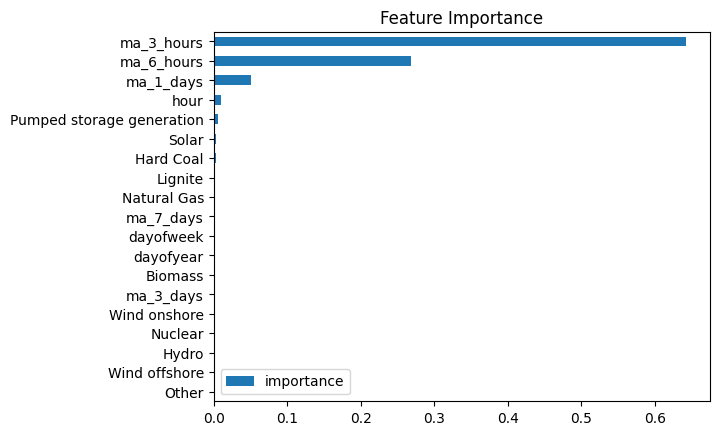

In [788]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [789]:
test['prediction'] = reg.predict(X_test)
test

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,...,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days,prediction
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-30 00:00:00,100.71,0.101101,0.145455,0.045090,0.260219,0.243971,0.0,0.049146,0.000022,0.000000,...,2,304,44,NaN,NaN,NaN,NaN,NaN,NaN,131.304962
2024-10-29 23:00:00,103.09,0.097725,0.149445,0.044872,0.274110,0.243789,0.0,0.046156,0.000599,0.000000,...,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN,132.212250
2024-10-29 22:00:00,118.08,0.095872,0.150584,0.047273,0.270704,0.255679,0.0,0.046154,0.001140,0.000000,...,1,303,44,107.293333,NaN,NaN,NaN,NaN,NaN,93.808144
2024-10-29 21:00:00,124.05,0.095560,0.150384,0.044436,0.265195,0.268427,0.0,0.046835,0.002805,0.000000,...,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN,104.753662
2024-10-29 20:00:00,140.60,0.093081,0.142999,0.047220,0.253702,0.278486,0.0,0.044794,0.014459,0.000000,...,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN,123.090195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-12 22:00:00,77.99,0.113293,0.023677,0.055367,0.130250,0.215225,0.0,0.048933,0.049053,0.000000,...,4,103,15,68.770000,49.866667,36.775833,18.733333,34.394444,59.200476,80.419472
2024-04-12 21:00:00,86.60,0.113721,0.024737,0.056448,0.127268,0.216605,0.0,0.048626,0.069500,0.000000,...,4,103,15,77.563333,61.065000,43.259167,20.702083,34.676250,59.321905,83.863342
2024-04-12 20:00:00,124.13,0.111542,0.026585,0.062115,0.137169,0.214550,0.0,0.053809,0.080439,0.000525,...,4,103,15,96.240000,77.685000,51.720000,23.133333,35.330556,59.666250,103.606155


In [790]:
merged_df = merged_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [791]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 12.96


In [792]:
# days and (absolute) error realtion
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean()

date
2024-04-12     9.667332
2024-04-13     8.437334
2024-04-14     8.889243
2024-04-15     8.020818
2024-04-16     5.927925
                ...    
2024-10-26     6.675152
2024-10-27     7.539611
2024-10-28     5.894424
2024-10-29    17.820232
2024-10-30    30.594962
Name: error, Length: 202, dtype: float64

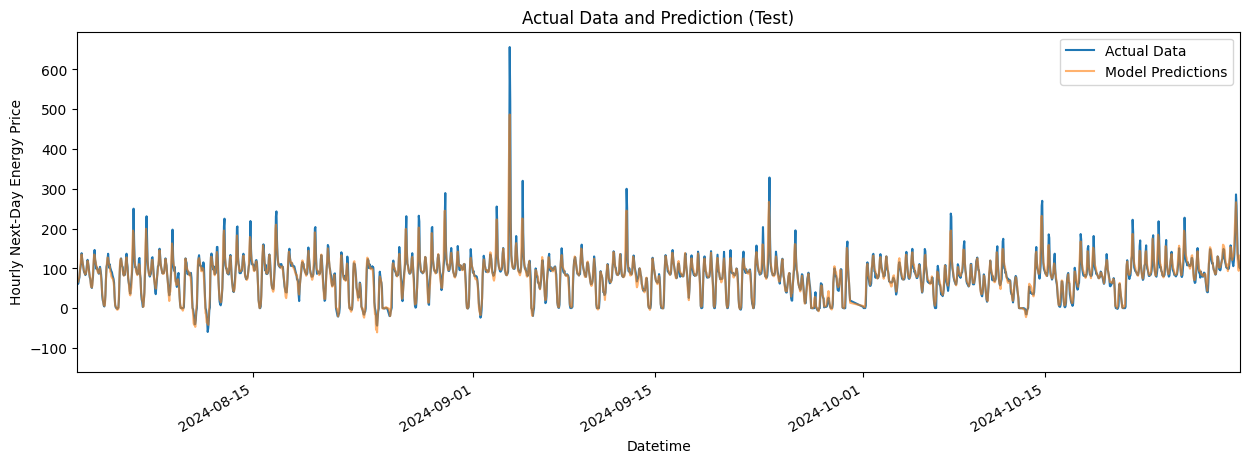

In [793]:

WINDOW = merged_df.iloc[:int(0.04 * (len(merged_df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
merged_df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')
plt.show()

In [794]:
date = '2024-10-29'
predictions = merged_df.loc[date, 'prediction']

# Display the result
print(predictions)

Datetime
2024-10-29 23:00:00    132.212250
2024-10-29 22:00:00     93.808144
2024-10-29 21:00:00    104.753662
2024-10-29 20:00:00    123.090195
2024-10-29 19:00:00    171.435944
2024-10-29 18:00:00    210.737732
2024-10-29 17:00:00    266.172943
2024-10-29 16:00:00    237.265640
2024-10-29 15:00:00    209.338135
2024-10-29 14:00:00    168.142502
2024-10-29 13:00:00    139.703644
2024-10-29 12:00:00    129.468918
2024-10-29 11:00:00    126.708878
2024-10-29 10:00:00    120.877068
2024-10-29 09:00:00    131.865829
2024-10-29 08:00:00    144.111115
2024-10-29 07:00:00    153.749939
2024-10-29 06:00:00    141.385681
2024-10-29 05:00:00    126.343765
2024-10-29 04:00:00    109.140450
2024-10-29 03:00:00    109.690979
2024-10-29 02:00:00     93.059715
2024-10-29 01:00:00    109.324104
2024-10-29 00:00:00    110.067116
Name: prediction, dtype: float32


save models pickel
add 500 to axis -> z-standardisation might also work
features?
register

